In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os

sns.set()

dataPath = '/Users/maxaragon/Desktop/11636748/ibl-behavioral-data-Dec2019'
os.chdir(dataPath)


In [2]:
##Code from IBL 

try:
    from oneibl.onelight import ONE
except ImportError:
    print("Error: Please install ibllib 1.4.7+ with `pip install ibllib`")
    exit()

one = ONE()

# Search all sessions that have these dataset types.
eids = one.search(['_ibl_trials.*'])

# Select the first session.
eid = eids[1]
print(f"Loading session {eid}.")

# List all dataset types available in that session.
dset_types = one.list(eid)

# Loading a single dataset.
choice = one.load_dataset(eid, dset_types[0])
print(choice)

# Loading an object.
print("Loading the _ibl_trials object.")
obj = one.load_object(eid, "_ibl_trials")
print("The example script ran successfully!")


Loading session angelakilab/Subjects/IBL-T1/2019-02-10/001.
Available dataset types: _ibl_trials.choice, _ibl_trials.contrastLeft, _ibl_trials.contrastRight, _ibl_trials.feedbackType, _ibl_trials.feedback_times, _ibl_trials.included, _ibl_trials.intervals, _ibl_trials.itiDuration, _ibl_trials.probabilityLeft, _ibl_trials.repNum, _ibl_trials.response_times, _ibl_trials.rewardVolume, _ibl_trials.stimOn_times
Loading _ibl_trials.choice
[-1  1  0  1  1  1 -1 -1  1 -1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1 -1
  1  1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1
 -1 -1 -1 -1 -1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1 -1  1 -1  1 -1 -1
 -1  1  1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1 -1 -1 -1  1  1
  1 -1 -1  1  1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1  1 -1  1 -1 -1 -1 -1 -1
 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1
 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1  1
  1 -1  1 -1  1  1 -1  1  1  1 -1 -1  1  1 -1  1 -1 

In [60]:
def loadData(eids):
    
    '''Extracts data from fully trained animals for each IBL lab.
        
        Inputs
        ------
        eids (list of strings): Contains directories for each experiment
        labs (list of strings): Contains lab names
        
        Outputs
        --------
        data (dict): Contains last day of data for each subject in each lab'''

    data = {}
    names = []
    labs = []
    
    #Get lab names 
    for eid in eids:
        lab = eid.split('/')[0]
        
        if lab not in labs:
            labs.append(lab)
        
    for lab in labs:
        labData = [eid for eid in eids if lab in eid] #all data for each lab
        subjects = [] #subject names

        #Get subject names for each lab
        for file in labData:
            subjects.append(file.split("Subjects")[-1].split('/')[1])
        uSubjs = np.unique(subjects) #unique subject names 

        #Get experiment from last day for each subject (fully-trained animals) 
        for subj in uSubjs:
            subjectData = [file for file in labData if subj in file]
            data[(lab,subj)] = one.load_object(subjectData[-1], '_ibl_trials') #only take data from last day
            names.append((lab,subj))
            
    return data,names,labs

def preprocData(data,names):
    '''Outputs
    ----------
    fullData (dict): One key for each lab. Dict values are lists (#features x #mice x #trials) 
    '''
    
    #Find min trial length across all experiments
    minLen = 10**6 #dummy length
    
    for name in names:
        testLen = len(data[name]['choice'])
        if testLen < minLen:
            minLen = testLen
            
    #Create data matrices
    labNames = np.unique(np.array(names)[:,0])
    fullData = [] #all data
    
    #Initialize arrays
    choiceMat = [] #L,R, or no-go
    levels = [] #indicates the group (lab) to which trial belongs
    choiceAR = [] #shifted choice 
    contrastMat = [] #stimulus contrast
    pleftMat = [] #probability of stim on left side
    prightMat = [] #probability of stim on right side
    
    #Compile data 
    for idx,labName in enumerate(labNames):

        for name in names:
            if labName in name:
                exp = data[name]
                contrast = [x if not np.isnan(x) else y 
                            for x,y in zip(exp['contrastLeft'],exp['contrastRight'])]

                contrastMat.append(contrast[1:minLen])
                
                #Process choices 
                choice = exp['choice']
                choice[choice==0] = np.random.choice([-1,1]) #randomly assign "no-go" to left or right (fix later?)
                choice[choice==-1] = 0
                choiceMat.append(choice[1:minLen])
                choiceAR.append(choice[0:minLen-1]) #autoregressive choice
                
                #Rest of predictors 
                pleftMat.append(exp['probabilityLeft'][1:minLen])
                prightMat.append(1 - exp['probabilityLeft'][1:minLen])
                idxMat = np.zeros(minLen-1)+idx
                levels.append(idxMat)
                
    predictors = (contrastMat,choiceAR,pleftMat,prightMat)

    return predictors,choiceMat,levels

#Load data 
data,names,labs = loadData(eids)
#Preprocess data
predictors,choices,levels = preprocData(data,names)
numPreds, numMice, numTrials = np.shape(predictors)
predictors = np.reshape(predictors,(-1,numMice*numTrials))
levels = np.reshape(levels,(numMice*numTrials)).astype('int')+1
choices = np.reshape(choices,(numMice*numTrials))

#Create final data structure
fullData = {'D': numPreds,
        'N': len(levels), 
        'L': len(np.unique(levels)), 
        'y': choices, 
        'll': levels, 
        'x': predictors.T}


In [50]:
model = '''
data{
    int<lower=1> D; // num predictors
    int<lower=0> N; // num samples 
    int<lower=1> L; // num groups
    int<lower=0,upper=1> y[N]; //targets
    int<lower=1,upper=L> ll[N]; //levels
    row_vector[D] x[N]; //predictors

}
parameters {
    real mu[D]; // population mean for predictor 
    real<lower=0> sigma[D]; //population std for predictor 
    vector[D] beta[L]; //regression coefficients for each predictor in each level 
}

model {
    for (d in 1:D){
        mu[d] ~ normal(0, 5); 
        
        for (l in 1:L)
            beta[l,d] ~ normal(mu[d], sigma[d]);
  }
  
    for (n in 1:N)
        y[n] ~ bernoulli(inv_logit(x[n] * beta[ll[n]]));
}'''

In [51]:
import pystan

#Compile model
sm = pystan.StanModel(model_code=model)

#Sample from posterior
fit = sm.sampling(data=fullData, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d77ca7b5665d2eee76c727b9fc2efcf NOW.


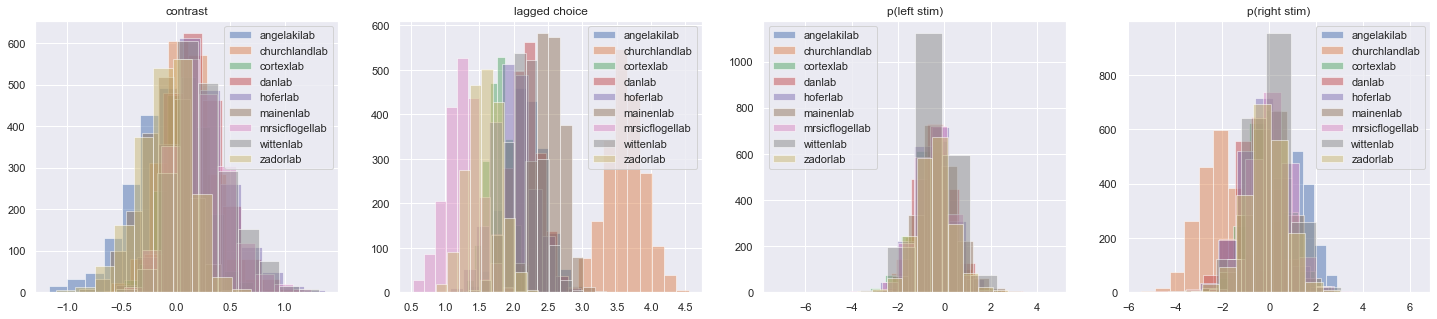

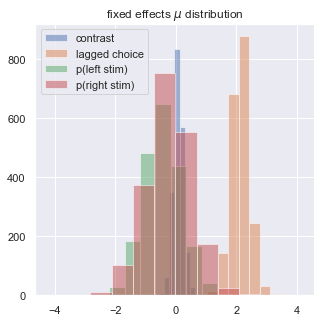

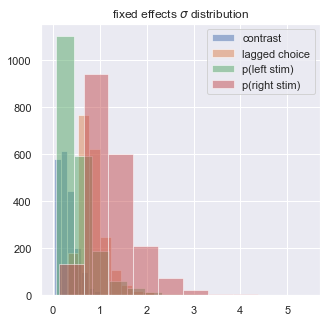

In [91]:

betas = fit['beta']
betas = betas.T
mus = fit['mu']
mus = mus.T
sigmas = fit['sigma']
sigmas = sigmas.T

betaLabels = ['contrast','lagged choice','p(left stim)','p(right stim)']

#Plot beta distributions across labs
fig,ax = plt.subplots(1,len(betaLabels),figsize = (25,5))

for idx0, beta in enumerate(betas):
    
    for idx1,lab in enumerate(beta):
        ax[idx0].hist(lab,alpha=0.5,label = labs[idx1])
    
    ax[idx0].set_title(betaLabels[idx0])
    ax[idx0].legend()

plt.show()

#Look at distribution of fixed effects means
fig,ax = plt.subplots(figsize = (5,5))

for idx0, mu in enumerate(mus):
    ax.hist(mu,alpha=0.5,label = betaLabels[idx0])
    ax.set_title('fixed effects $\mu$ distribution')
    ax.legend()

plt.show()
    

#Look at distribution of fixed effects sigma
fig,ax = plt.subplots(figsize = (5,5))

for idx0, sig in enumerate(sigmas):
    ax.hist(sig,alpha=0.5,label = betaLabels[idx0])
    ax.set_title('fixed effects $\sigma$ distribution')
    ax.legend()

plt.show()
    

In [85]:
print(fit)

Inference for Stan model: anon_model_6d77ca7b5665d2eee76c727b9fc2efcf.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
mu[1]        0.08  5.9e-3   0.17  -0.25  -0.02   0.08    0.19   0.43    825    1.0
mu[2]        2.14  9.5e-3    0.3   1.55   1.95   2.13    2.32   2.74    998   1.01
mu[3]       -0.43    0.05   0.63  -1.61  -0.86  -0.44   -0.04   0.83    186   1.02
mu[4]       -0.24    0.04   0.75  -1.78  -0.71  -0.23    0.28   1.16    287   1.01
sigma[1]      0.3    0.02    0.2   0.04   0.15   0.27     0.4   0.78    130   1.04
sigma[2]     0.84  9.6e-3   0.28   0.46   0.65   0.79    0.97   1.55    871    1.0
sigma[3]     0.51    0.03   0.41   0.09   0.23   0.41    0.66   1.62    258   1.01
sigma[4]     1.26    0.02   0.56   0.52   0.88   1.13    1.51   2.66    792    1.0
beta[1,1]   -0.16    0.01   0.27  -0.81  -0.32  -0.13    0.04   0.

In [93]:
np.shape(mus)

(4, 2000)